In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from data_helper import LabeledDataset
from helper import collate_fn
from road_map_construction import RoadMapNetwork

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda:0")  # cuda:0 if gpu is available

def load_model(path):
    model = RoadMapNetwork.load_from_checkpoint(path)
    model.to(device)

    return model

def val_dataloader(batch_size=2):
    # All the images are saved in image_folder
    # All the labels are saved in the annotation_csv file
    image_folder = '../data'
    annotation_csv = '../data/annotation.csv'

    # The scenes from 106 - 133 are labeled
    # You should divide the labeled_scene_index into two subsets (training and validation)
    labeled_scene_index = np.arange(106, 134)
    validation_index = labeled_scene_index[:8]

    # The labeled dataset can only be retrieved by sample.
    # And all the returned data are tuple of tensors, since bounding boxes may have different size
    # You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.54, 0.60, 0.63), (0.34, 0.34, 0.34)
            ),
        ]
    )

    labeled_validset = LabeledDataset(
        image_folder=image_folder,
        annotation_file=annotation_csv,
        scene_index=validation_index,
        transform=transform,
        extra_info=False
    )
    
    return torch.utils.data.DataLoader(
        labeled_validset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )

In [2]:
model = load_model("./lightning_logs_road_map/version_1/checkpoints/epoch=24.ckpt")
model.freeze()

# Loading the validation data
# Use a smaller batch size if you get a memory error
valid_loader = val_dataloader(model.hparams.BATCH_SIZE)

In [3]:
sample, target, road_image = iter(valid_loader).next()
sample = torch.stack(sample)
road_image = torch.stack(road_image).float()

sample = sample.to(device)

pred_road_image = torch.sigmoid(model(sample))
pred_road_image = pred_road_image.detach().cpu()

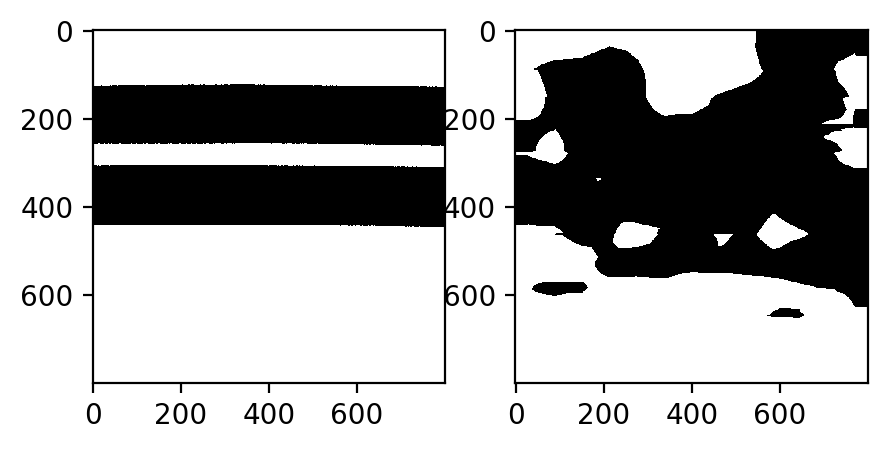

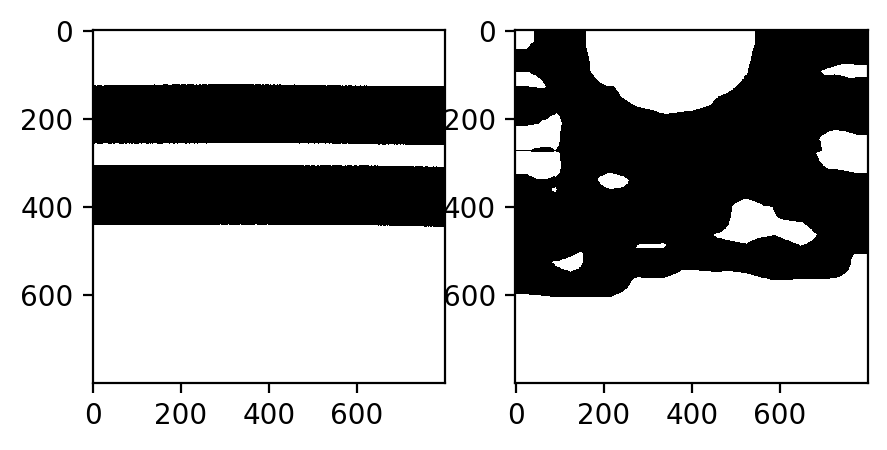

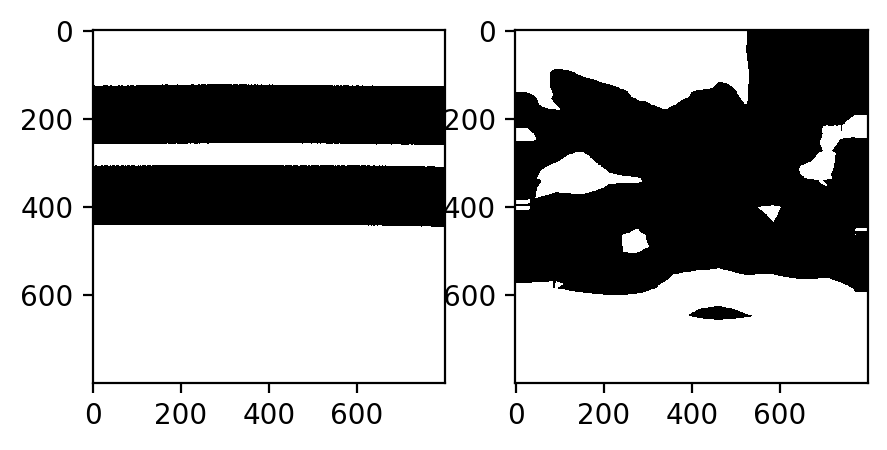

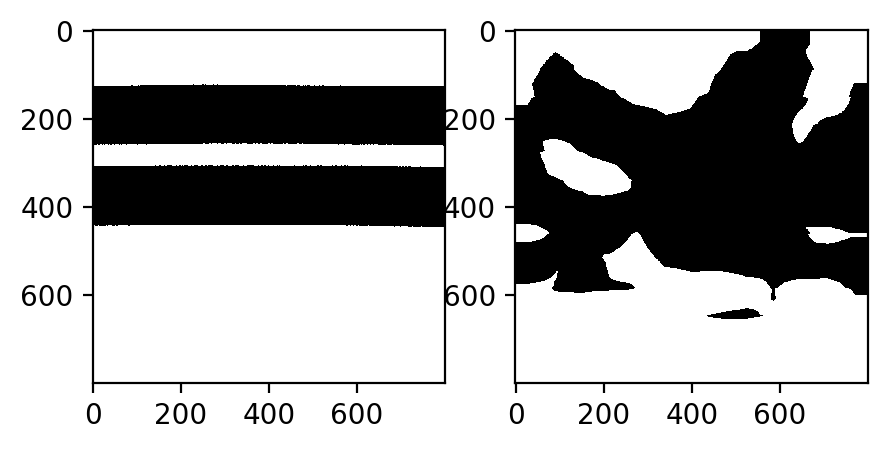

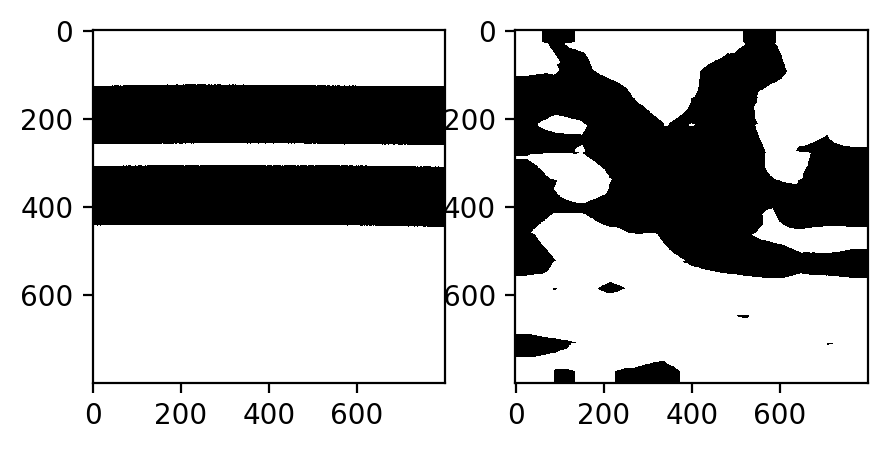

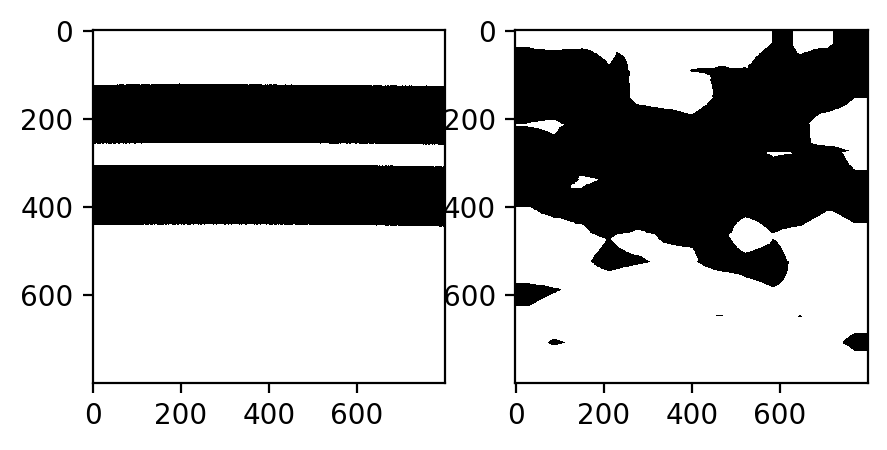

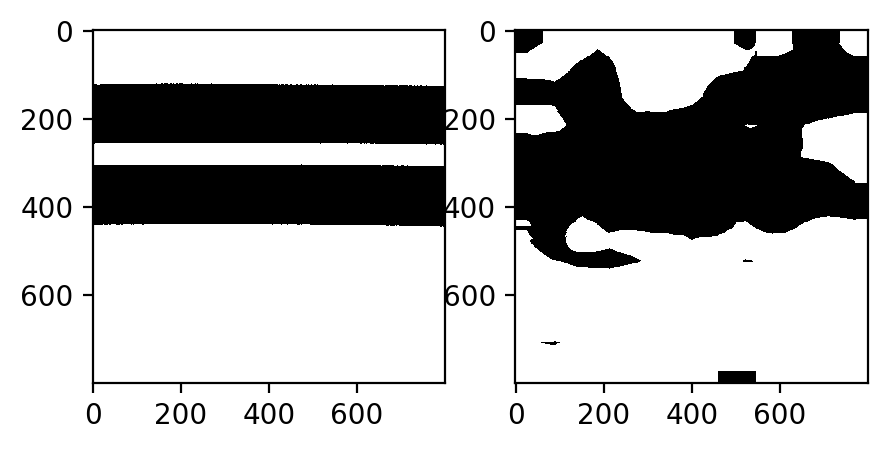

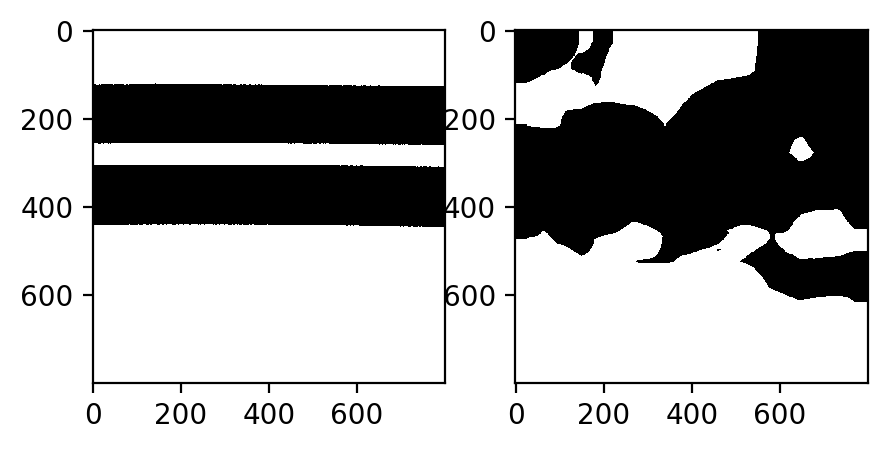

In [8]:
for idx in range(model.hparams.BATCH_SIZE):
    plt.subplot(1, 2, 1)
    plt.imshow(road_image[idx], cmap='binary');

    plt.subplot(1, 2, 2)
    plt.imshow((pred_road_image[idx] > 0.33).numpy(), cmap='binary')

    plt.show()